In [1]:
import os
import math
import torch
from loguru import logger
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Qwen2Config,
    Qwen2ForCausalLM,
    Qwen2Tokenizer,
    get_cosine_schedule_with_warmup,
)
from tqdm import tqdm

from transformers import BitsAndBytesConfig

from torch.cuda.amp import autocast, GradScaler
import numpy as np
from torch.optim import AdamW
from accelerate import Accelerator






import pandas as pd
from collections import defaultdict
import re

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Суть проекта

Можно описать её одним предложением: выяснить кто в интернете не прав. 

https://jeremybernste.in/writing/deriving-muon  - существует блог товарища, который писал оптимизатор MuON, в этом посте он описывает что же конкретно с точки зрения математики происходит в оптимизаторе. К нему в комменты приходит другой человек и задаёт резонный вопрос: 

"Вы говорите, что у вас совсем не эврестический подход к построению вашего оптимизатор, чем вы гордитесь, но выбор приведения нормы RMS->RMS кажется ни на чем не основан, может есть другие варианты"? 

И уже дальше второй комментатор выдывигает тезис: "конкретно для задачи классификации кажется более логичным было бы использовать L1->RMS". 

Задача: попытаться выяснить так ли это.

Для данного таска была выбрана задача классификации, коль по условию мы исходим из последнего комментария, при этом наш датасет должен занимать время на обработку, не быть совсем легковесным и в то же время его должно быть возможно прогнать на моей локальной машине с 6gb VRAM и ~12 гб ОЗУ, так как все бесплатные коллабы к моменту написания этого введения я уже съел.

Для этого возьму данные и задачу по классификации комментариев на токсичные и нормальные 

- Данные: https://habr.com/ru/companies/ru_mts/articles/585804/
- Нейросеть нагенерю сам какую-то супер простую

На основе одних и тех же данных и единой структуры нейросети попробую посмотреть на сходимость и скорость тренировки MuON, MuON_L1_RMS и ADAMW. 

In [2]:
data_another = pd.read_csv('data/toxic/labeled.csv', on_bad_lines='skip', sep=',', # оба датафрейма читались из хабра МТС выше.
                    encoding='UTF-8',
                    engine='python',)
data_another 

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [3]:
and_another_one = pd.read_table('data/toxic/dataset.txt', on_bad_lines='skip',  # оба датафрейма читались из хабра МТС выше.
                    encoding='UTF-8',
                    engine='python', header=None)
and_another_one

,0
0,__label__INSULT скотина! что сказать
1,__label__NORMAL я сегодня проезжала по рабочей...
2,__label__NORMAL очередной лохотрон. зачем прид...
3,__label__NORMAL ретро дежавю ... сложно понять...
4,__label__NORMAL а когда мы статус агрогородка ...
...,...
248285,__label__NORMAL правильно всё по пять (5)...
248286,__label__INSULT ёбанные нубы заходите на серве...
248287,__label__NORMAL а у меня наверное рекорд в 196...
248288,__label__NORMAL спасибо всем большое)


Предобработка данных

In [4]:
def set_toxicity(x):
    if x[0:15] == '__label__NORMAL':
        return 0
    else:
        return 1

In [5]:
and_another_one['toxic'] = and_another_one[0].apply(set_toxicity)
and_another_one.columns = ['comment', 'toxic']


In [6]:
and_another_one['comment'] = and_another_one['comment'].str.replace('__label__INSULT', '')
and_another_one['comment'] = and_another_one['comment'].str.replace('__label__THREAT', '')
and_another_one['comment'] = and_another_one['comment'].str.replace('__label__NORMAL ', '')
and_another_one['comment'] = and_another_one['comment'].str.replace('__label__OBSCENITY', '')
and_another_one['comment']

0                                      скотина! что сказать
1         я сегодня проезжала по рабочей и между домами ...
2         очередной лохотрон. зачем придумывать очередно...
3         ретро дежавю ... сложно понять чужое сердце , ...
4                   а когда мы статус агрогородка получили?
                                ...                        
248285                         правильно всё по пять (5)...
248286     ёбанные нубы заходите на сервер мой ник _cree...
248287    а у меня наверное рекорд в 1962 году в училище...
248288                                спасибо всем большое)
248289    нельзя ли увеличить хотя бы в два раза некотор...
Name: comment, Length: 248290, dtype: object

In [7]:
and_another_one.loc[and_another_one['toxic']==0]

,comment,toxic
1,я сегодня проезжала по рабочей и между домами ...,0
2,очередной лохотрон. зачем придумывать очередно...,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0
4,а когда мы статус агрогородка получили?,0
5,2 августа поздно вечером нашли вот такую потер...,0
...,...,...
248284,"это евгений леонов,а алексей леонов -космонавт.",0
248285,правильно всё по пять (5)...,0
248287,а у меня наверное рекорд в 1962 году в училище...,0
248288,спасибо всем большое),0


In [8]:
df = pd.concat([and_another_one, data_another], ignore_index = True)
df.head()

,comment,toxic
0,скотина! что сказать,1.0
1,я сегодня проезжала по рабочей и между домами ...,0.0
2,очередной лохотрон. зачем придумывать очередно...,0.0
3,"ретро дежавю ... сложно понять чужое сердце , ...",0.0
4,а когда мы статус агрогородка получили?,0.0


In [9]:
print(df.shape)
df = df.drop_duplicates()
df.shape

(262702, 2)


(262702, 2)

In [10]:
special_character_removal=re.compile(r'[^?!.,:а-яё\d ]',re.IGNORECASE)

# regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)
word_count_dict = defaultdict(int)
toxic_dict = {}
def clean_text(text, remove_stopwords=False, stem_words=False, count_null_words=True, clean_wiki_tokens=True):
    # Clean the text, with the option to remove stopwords and to stem words.
    # dirty words
    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = special_character_removal.sub('',text)
    return text

def clean_wylkoi(x):
    return re.sub(r'[^\w\\]+', ' ', x.lower())

In [11]:
df['git_comment'] = df['comment'].apply(clean_text) # git - потому что брал код с гита, но ссылку потерял
df['my_comment'] = df['git_comment'].apply(clean_wylkoi)
df

,comment,toxic,git_comment,my_comment
0,скотина! что сказать,1.0,скотина ! что сказать,скотина что сказать
1,я сегодня проезжала по рабочей и между домами ...,0.0,я сегодня проезжала по рабочей и между домами ...,я сегодня проезжала по рабочей и между домами ...
2,очередной лохотрон. зачем придумывать очередно...,0.0,очередной лохотрон зачем придумывать очередно...,очередной лохотрон зачем придумывать очередной...
3,"ретро дежавю ... сложно понять чужое сердце , ...",0.0,ретро дежавю сложно понять чужое сердце ...,ретро дежавю сложно понять чужое сердце лиш ощ...
4,а когда мы статус агрогородка получили?,0.0,а когда мы статус агрогородка получили ?,а когда мы статус агрогородка получили
...,...,...,...,...
262697,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,вонючий совковый скот прибежал и ноет а вот и...,вонючий совковый скот прибежал и ноет а вот и ...
262698,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,а кого любить ? гоблина тупорылого что ли ? ...,а кого любить гоблина тупорылого что ли или ка...
262699,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,посмотрел утомленных солнцем 2 и оказалось ч...,посмотрел утомленных солнцем 2 и оказалось что...
262700,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,крымотред нарушает правила раздела т к в нем н...,крымотред нарушает правила раздела т к в нем н...


In [12]:
from pymystem3 import Mystem

m = Mystem()
lemmas = m.lemmatize(df['my_comment'][1])
print(''.join(lemmas))



я сегодня проезжать по рабочий и между дом снитенко и гомолысова магазин на пустырь бежать кошка похожий окрас мочь я и ошибаться но необычный окрас бросаться в глаз 



In [13]:
tqdm.pandas()

In [14]:

df['my_comment'].progress_apply(lambda x: ''.join(m.lemmatize(x) ) )

  0%|          | 23/262702 [00:13<41:44:08,  1.75it/s]


KeyboardInterrupt: 

Есть у меня одна любимая история про лемматизации текстов и оптимизацию этого процесса. Существует такая компания маленькая, Яндекс называется, которая иногда выпускает in-public свои не лучшие решения (если что без негатива персонально к яндексоидам, сам там год работал, но тут я правда не понимаю что и почему так, хотя и допускаю, что есть причины на всё описанное ниже).

так вот, есть такое решение как pymystem3. Отличная библиотека, которая делает хорошую лемматизацию русских текстов. Но есть нюанс. При её вызове каждый раз инициализируется, какой-то чудовищный по затратам времени, запуск exe файла. Который, уж не знаю почему, совершенно точно нельзя единожды запихнуть в Mystem(). И каждый раз он занимает огромную гору времени (можно посмотреть выше в стопнутую ячейку сколько он предполагает лемматизировать текст dataframe построчно), в то время как каждое предложение на самом деле лемматизируется не больше секунды. 

И одновременно с этим, если запихнуть все эти тексты в одну строку, в которой оставить между текстами сепаратор типа ' br ', то вся эта вакханалия, займёт не больше пары минут. Потому что сколь бы большим предложение не было, лемматизироваться оно будет в момент.

Короче пока корабли ФКН бороздят просторы оптимизации больших нейронных сетей на проде у тысяч айтишников висит вот эти фигня, съедающая немалое количество человеко-часов.

In [14]:
def checkExecTimeMystemOneText(texts):
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 1000)
    res = []
    for txtp in tqdm(txtpart):
        alltexts = ' '.join([txt + ' br ' for txt in txtp])

        words = m.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(' '.join(doc))
                    doc = []
                else:
                    doc.append(txt)

    return res

In [15]:
m = Mystem()
df['lemmas'] = checkExecTimeMystemOneText(df['my_comment'])
df

100%|██████████| 263/263 [04:11<00:00,  1.05it/s]


,comment,toxic,git_comment,my_comment,lemmas
0,скотина! что сказать,1.0,скотина ! что сказать,скотина что сказать,скотина что сказать
1,я сегодня проезжала по рабочей и между домами ...,0.0,я сегодня проезжала по рабочей и между домами ...,я сегодня проезжала по рабочей и между домами ...,я сегодня проезжать по рабочий и между дом сни...
2,очередной лохотрон. зачем придумывать очередно...,0.0,очередной лохотрон зачем придумывать очередно...,очередной лохотрон зачем придумывать очередной...,очередной лохотрон зачем придумывать очередной...
3,"ретро дежавю ... сложно понять чужое сердце , ...",0.0,ретро дежавю сложно понять чужое сердце ...,ретро дежавю сложно понять чужое сердце лиш ощ...,ретро дежавю сложно понимать чужой сердце лиш ...
4,а когда мы статус агрогородка получили?,0.0,а когда мы статус агрогородка получили ?,а когда мы статус агрогородка получили,а когда мы статус агрогородок получать
...,...,...,...,...,...
262697,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,вонючий совковый скот прибежал и ноет а вот и...,вонючий совковый скот прибежал и ноет а вот и ...,вонючий совковый скот прибегать и ныть а вот и...
262698,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,а кого любить ? гоблина тупорылого что ли ? ...,а кого любить гоблина тупорылого что ли или ка...,а кто любить гоблин тупорылый что ли или какой...
262699,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,посмотрел утомленных солнцем 2 и оказалось ч...,посмотрел утомленных солнцем 2 и оказалось что...,посмотреть утомленный солнце 2 и оказываться ч...
262700,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,крымотред нарушает правила раздела т к в нем н...,крымотред нарушает правила раздела т к в нем н...,крымотред нарушать правило раздел т к в он нет...


In [34]:
# df.to_csv('data/radi_hrista_sohrany.csv', index=False)

# Нейросеть

## Оптимизаторы

Дальше будет несколько ячеек эволюции MuON, первую версию которого мне скинул Стас. Есть нюанс в том, что запускается она несколько геморно и в то же время у меня возникали с ней проблемы. Нашёл актуальный репозиторий оптимизатора, там всё сильно лучше, но есть второй нюанс. Она работает на распределённых вычислениях, которые хороши, когда у вас много GPU, но вообще не применимо когда у вас одна старая 1060. 

Короче, даже имея как бы "готовый" оптимизатор, причём дважды "готовый", мне пришлось его переписывать, чтобы он просто запустился на моей машине. 

Я **очень** надеюсь, что при этом я не убил никакой логики MuON. 

### Первая версия

In [41]:

@torch.compile
def zeropower_via_newtonschulz5(G, steps):
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T
    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = (
            b * A + c * A @ A
        )  
        X = a * X + B @ X

    if G.size(0) > G.size(1):
        X = X.T
    return X

class Muon_default(torch.optim.Optimizer):

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - We believe this optimizer is unlikely to work well for training with small batch size.
    - We believe it may not work well for finetuning pretrained models, but we haven't tested this.

    Arguments:
        muon_params: The parameters to be optimized by Muon.
        lr: The learning rate. The updates will have spectral norm of `lr`. (0.02 is a good default)
        momentum: The momentum used by the internal SGD. (0.95 is a good default)
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        ns_steps: The number of Newton-Schulz iterations to run. (6 is probably always enough)
        adamw_params: The parameters to be optimized by AdamW. Any parameters in `muon_params` which are
        {0, 1}-D or are detected as being the embed or lm_head will be optimized by AdamW as well.
        adamw_lr: The learning rate for the internal AdamW.
        adamw_betas: The betas for the internal AdamW.
        adamw_eps: The epsilon for the internal AdamW.
        adamw_wd: The weight decay for the internal AdamW.
    """

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

                # RMS-L1 Normalization for the final layer
                if "lm_head.weight" in p.name:  # Adjust this condition if your final layer has a different name
                    w = p.data
                    rms = torch.sqrt(torch.mean(w**2))
                    l1 = torch.sum(torch.abs(w))
                    p.data = w / (rms + 1e-8)  # Add a small epsilon to avoid division by zero
                    p.data = p.data / (torch.sum(torch.abs(p.data)) + 1e-8)



            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

def get_optimizer(optimizer_name, model, lr=1e-3, wd=0.1):
        if optimizer_name == "adamw":
            return torch.optim.AdamW(
                model.parameters(), lr=lr, weight_decay=wd, betas=(0.9, 0.95)
            )
        elif optimizer_name == "muon":
            muon_params = [
                p
                for name, p in model.named_parameters()
                if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            ]
            adamw_params = [
                p
                for name, p in model.named_parameters()
                if not (
                    p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
                )
            ]
    
            return Muon_default(
                lr=lr,
                wd=wd,
                muon_params=muon_params,
                adamw_params=adamw_params,
            )

        elif optimizer_name == "muon_l1":
            muon_params = [
                p
                for name, p in model.named_parameters()
                if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            ]
            adamw_params = [
                p
                for name, p in model.named_parameters()
                if not (
                    p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
                )
            ]
    
            return Muon(
                lr=lr,
                wd=wd,
                muon_params=muon_params,
                adamw_params=adamw_params,
            )
            
        else:
            assert 0, "optimizer not supported"

### Более новая версия MuON

In [79]:
import os
import torch
import torch.distributed as dist
from torch import Tensor

def zeropower_via_newtonschulz5(G: Tensor, steps: int) -> Tensor:
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X
    
    if G.size(-2) > G.size(-1):
        X = X.mT
    return X

class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    https://kellerjordan.github.io/posts/muon/

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - This optimizer should not be used for the embedding layer, the final fully connected layer,
    or any {0,1}-D parameters; those should all be optimized by a standard method (e.g., AdamW).
    - To use it with 4D convolutional filters, it works well to just flatten their last 3 dimensions.

    Arguments:
        lr: The learning rate used by the internal SGD.
        momentum: The momentum used by the internal SGD.
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        ns_steps: The number of Newton-Schulz iteration steps to use.
    """
    def __init__(self, params, lr=0.02, weight_decay=0.01, momentum=0.95, nesterov=True, ns_steps=5, rank=None, world_size=None):
        if (rank is None) or (world_size is None):
            raise Exception("world_size and rank params required, if you want to use this optimizer on a single GPU, pass rank=0 and world_size=1.")
        self.rank = rank
        self.world_size = world_size
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov, ns_steps=ns_steps)
        params: list[Tensor] = [*params]
        param_groups = []
        for size in {p.numel() for p in params}:
            b = torch.empty(world_size, size, dtype=torch.bfloat16, device="cuda")
            group = dict(params=[p for p in params if p.numel() == size],
                         update_buffer=b, update_buffer_views=[b[i] for i in range(world_size)])
            param_groups.append(group)
        super().__init__(param_groups, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            update_buffer: Tensor = group["update_buffer"]
            update_buffer_views: list[Tensor] = group["update_buffer_views"]
            # generate weight updates in distributed fashion
            params: list[Tensor] = group["params"]
            handle = None
            params_world = None
            def update_prev(): # optimized Muon implementation contributed by @YouJiacheng
                handle.wait()
                for p_world, g_world in zip(params_world, update_buffer_views):
                    p_world.mul_(1 - group["lr"] * group["weight_decay"])
                    p_world.add_(g_world.view_as(p_world),
                                 alpha=-group["lr"] * max(1, p_world.size(-2) / p_world.size(-1))**0.5)
            for base_i in range(len(params))[::self.world_size]:
                if base_i + self.rank < len(params):
                    p = params[base_i + self.rank]
                    g = p.grad
                    assert g is not None
                    state = self.state[p]
                    if "momentum_buffer" not in state:
                        state["momentum_buffer"] = torch.zeros_like(g)
                    buf: Tensor = state["momentum_buffer"]
                    buf.lerp_(g, 1 - group["momentum"])
                    g = g.lerp_(buf, group["momentum"]) if group["nesterov"] else buf
                    if g.ndim == 4: # for the case of conv filters
                        g = g.view(len(g), -1)
                    g = zeropower_via_newtonschulz5(g, steps=group["ns_steps"]).flatten()
                else:
                    g = update_buffer_views[self.rank]
                if base_i > 0:
                    update_prev() # async all_gather instead of sync all_reduce by @YouJiacheng
                handle = dist.all_gather_into_tensor(update_buffer, g, async_op=True)
                params_world = params[base_i : base_i + self.world_size]
            update_prev()

### rewriten without distributed computations. 

моя уверенность, что я не проебал нигде логику изначального оптимизатора: молюсь об этом перед сном

In [82]:
import os
import torch
import torch.distributed as dist
from torch import Tensor

def zeropower_via_newtonschulz5(G: Tensor, steps: int) -> Tensor:
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X
    
    if G.size(-2) > G.size(-1):
        X = X.mT
    return X




class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    https://kellerjordan.github.io/posts/muon/

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - This optimizer should not be used for the embedding layer, the final fully connected layer,
    or any {0,1}-D parameters; those should all be optimized by a standard method (e.g., AdamW).
    - To use it with 4D convolutional filters, it works well to just flatten their last 3 dimensions.

    Arguments:
        lr: The learning rate used by the internal SGD.
        momentum: The momentum used by the internal SGD.
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        ns_steps: The number of Newton-Schulz iteration steps to use.
    """
    def __init__(self, params, lr=0.02, weight_decay=0.01, momentum=0.95, nesterov=True, ns_steps=5):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov, ns_steps=ns_steps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for p in self.param_groups[0]['params']:
            g = p.grad
            assert g is not None
            state = self.state[p]
            if "momentum_buffer" not in state:
                state["momentum_buffer"] = torch.zeros_like(g)
            buf: Tensor = state["momentum_buffer"]
            buf.lerp_(g, 1 - self.param_groups[0]["momentum"])
            g = g.lerp_(buf, self.param_groups[0]["momentum"]) if self.param_groups[0]["nesterov"] else buf
            if g.ndim == 4: # for the case of conv filters
                g = g.view(len(g), -1)
            g = zeropower_via_newtonschulz5(g, steps=self.param_groups[0]["ns_steps"]).flatten()
            p.mul_(1 - self.param_groups[0]["lr"] * self.param_groups[0]["weight_decay"])
            p.add_(g.view_as(p),
                   alpha=-self.param_groups[0]["lr"] * max(1, p.size(-2) / p.size(-1))**0.5)

### Prep to neural network train

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd


dataset = df[['lemmas', 'toxic']].copy()  

pretrained tokenizer taken. Honestly randomest choice in my life
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = MoonDataset(
    texts=train_df["lemmas"].tolist(),
    labels=train_df["toxic"].tolist(),
    tokenizer=tokenizer,
    max_length=256,
)
test_dataset = MoonDataset(
    texts=test_df["lemmas"].tolist(),
    labels=test_df["toxic"].tolist(),
    tokenizer=tokenizer,
    max_length=256,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Super simple try - doesn`t give significant accuracy growth  throug train
# class TextClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length):
#         super(TextClassifier, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, num_classes)
#         self.max_length = max_length

#     def forward(self, x):
#         x = self.embedding(x)
#         _, h_n = self.rnn(x)
#         h_n = h_n.squeeze(0)
#         output = self.fc(h_n)
#         return output

In [94]:
# commented code from prev iterations of war with MuON

In [ ]:
# import torch.distributed as dist
# import os
# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["USE_LIBUV"] = "0"
# dist.init_process_group(backend='nccl', init_method='env://', rank = torch.cuda.device_count(), world_size = 1)
# Initialize the process group

# dist.init_process_group(backend="gloo", init_method="env://", rank=0, world_size=1)

## MuON classic

In [86]:


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        scores = self.Va(torch.tanh(self.Wa(hidden_states) + self.Ua(hidden_states)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.permute(0, 2, 1), hidden_states).squeeze(1)
        return context_vector, attention_weights

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_rate)
        self.attention = Attention(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        context_vector, attention_weights = self.attention(x)
        output = self.fc(context_vector)
        return output

# Training loop
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []

        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            # for opt in optimizer:
            #     opt.zero_grad()
                
            loss.backward()
            
            for opt in optimizer:
                opt.step()

            model.zero_grad(set_to_none=True)
            # Collect metrics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_train_preds.extend(predicted.cpu().numpy())
            epoch_train_labels.extend(labels.cpu().numpy())

        # Calculate training accuracy
        epoch_train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation on test set
        model.eval()
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                epoch_test_preds.extend(predicted.cpu().numpy())
                epoch_test_labels.extend(labels.cpu().numpy())

        epoch_test_accuracy = accuracy_score(epoch_test_labels, epoch_test_preds)
        epoch_test_loss /= len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# hyperpams
vocab_size = 119547  
hidden_dim = 256
num_classes = 2  
max_length = 256
num_epochs = 5
batch_size = 8
learning_rate = .001
weight_decay = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes, max_length)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

muon_params = [p for p in model.rnn.parameters() if p.ndim >= 2]
adamw_params = ([p for p in model.rnn.parameters() if p.ndim < 2]
              + list(model.embedding.parameters())
              + list(model.attention.parameters())
              + list(model.fc.parameters())
              + list(model.dropout.parameters()))

mu_opti = Muon(muon_params, lr=0.02, momentum=0.95)

optimizers = [
    mu_opti,
    torch.optim.AdamW(adamw_params, lr=learning_rate, betas=(0.90, 0.95), weight_decay=0.01)
]

for opt in optimizers:
    for group in opt.param_groups:
        group["initial_lr"] = group["lr"]

100%|██████████| 26271/26271 [25:16<00:00, 17.32it/s]


Epoch 1/5:
Train Loss: 0.4601, Train Accuracy: 0.8152
Test Loss: 0.4581, Test Accuracy: 0.8114


100%|██████████| 26271/26271 [25:11<00:00, 17.39it/s]


Epoch 2/5:
Train Loss: 0.4750, Train Accuracy: 0.8099
Test Loss: 0.4654, Test Accuracy: 0.8104


100%|██████████| 26271/26271 [25:12<00:00, 17.37it/s]


Epoch 3/5:
Train Loss: 0.4769, Train Accuracy: 0.8102
Test Loss: 0.4572, Test Accuracy: 0.8119


100%|██████████| 26271/26271 [25:16<00:00, 17.33it/s]


Epoch 4/5:
Train Loss: 0.4808, Train Accuracy: 0.8099
Test Loss: 0.4729, Test Accuracy: 0.8103


100%|██████████| 26271/26271 [25:14<00:00, 17.34it/s]


Epoch 5/5:
Train Loss: 0.4821, Train Accuracy: 0.8095
Test Loss: 0.4698, Test Accuracy: 0.8101


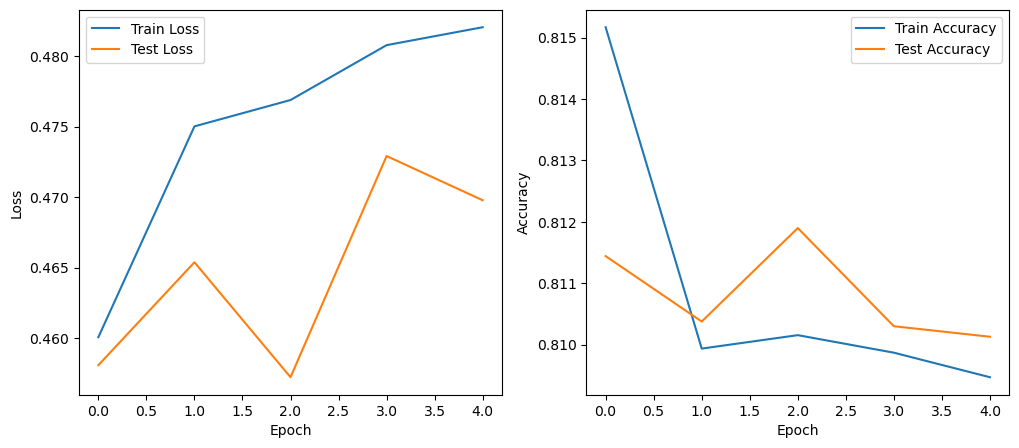

In [87]:


# Train the mode
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, optimizers, criterion, num_epochs, device
)

# Plot results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [88]:
muon_simple = {
               'test_losses': test_losses,
               'train_losses':train_losses,
               'train_accuracies':train_accuracies,
               'test_accuracies':  test_accuracies
              } 

muon_simple

{'test_losses': [0.45807239883006456,
  0.4653738799928058,
  0.4572181827167501,
  0.47291148290373886,
  0.46977429142410115],
 'train_losses': [0.4600604398555821,
  0.4750154730892407,
  0.47688496447590545,
  0.4807783738392668,
  0.48205044148527765],
 'train_accuracies': [0.8151702742183373,
  0.8099361917767807,
  0.8101550715879731,
  0.8098695761820699,
  0.8094698826138056],
 'test_accuracies': [0.8114424925296435,
  0.8103766582288118,
  0.8118992786585714,
  0.8103005272073238,
  0.8101292324089758]}

In [47]:
adam_simple

{'test_losses': [0.4961309000922324, 0.4950909514284163, 0.49871998202695483],
 'train_losses': [0.49204724586844684, 0.4918178864429477, 0.4917184129838899],
 'train_accuracies': [0.812467584375788, 0.812467584375788, 0.812467584375788],
 'test_accuracies': [0.80931082392798, 0.80931082392798, 0.80931082392798]}

## ADAMW

In [95]:


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        scores = self.Va(torch.tanh(self.Wa(hidden_states) + self.Ua(hidden_states)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.permute(0, 2, 1), hidden_states).squeeze(1)
        return context_vector, attention_weights

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_rate)
        self.attention = Attention(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        context_vector, attention_weights = self.attention(x)
        output = self.fc(context_vector)
        return output

# Training loop
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []

        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            # for opt in optimizer:
            #     opt.zero_grad()
                
            loss.backward()
            
            for opt in optimizer:
                opt.step()

            model.zero_grad(set_to_none=True)
            # Collect metrics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_train_preds.extend(predicted.cpu().numpy())
            epoch_train_labels.extend(labels.cpu().numpy())

        # Calculate training accuracy
        epoch_train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation on test set
        model.eval()
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                epoch_test_preds.extend(predicted.cpu().numpy())
                epoch_test_labels.extend(labels.cpu().numpy())

        epoch_test_accuracy = accuracy_score(epoch_test_labels, epoch_test_preds)
        epoch_test_loss /= len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# hyperpams
vocab_size = 119547  
hidden_dim = 256
num_classes = 2  
max_length = 256
num_epochs = 5
batch_size = 8
learning_rate = .001
weight_decay = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes, max_length)
criterion = nn.CrossEntropyLoss()
optimizers = [torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.90, 0.95), weight_decay=0.01)]




100%|██████████| 26271/26271 [19:40<00:00, 22.25it/s]


Epoch 1/5:
Train Loss: 0.1624, Train Accuracy: 0.9458
Test Loss: 0.1786, Test Accuracy: 0.9476


100%|██████████| 26271/26271 [19:46<00:00, 22.15it/s]


Epoch 2/5:
Train Loss: 0.1311, Train Accuracy: 0.9585
Test Loss: 0.1465, Test Accuracy: 0.9581


100%|██████████| 26271/26271 [19:47<00:00, 22.12it/s]


Epoch 3/5:
Train Loss: 0.1311, Train Accuracy: 0.9586
Test Loss: 0.1327, Test Accuracy: 0.9573


100%|██████████| 26271/26271 [20:41<00:00, 21.17it/s]


Epoch 4/5:
Train Loss: 0.1305, Train Accuracy: 0.9582
Test Loss: 0.1373, Test Accuracy: 0.9573


100%|██████████| 26271/26271 [20:46<00:00, 21.07it/s]


Epoch 5/5:
Train Loss: 0.1340, Train Accuracy: 0.9577
Test Loss: 0.1788, Test Accuracy: 0.9494


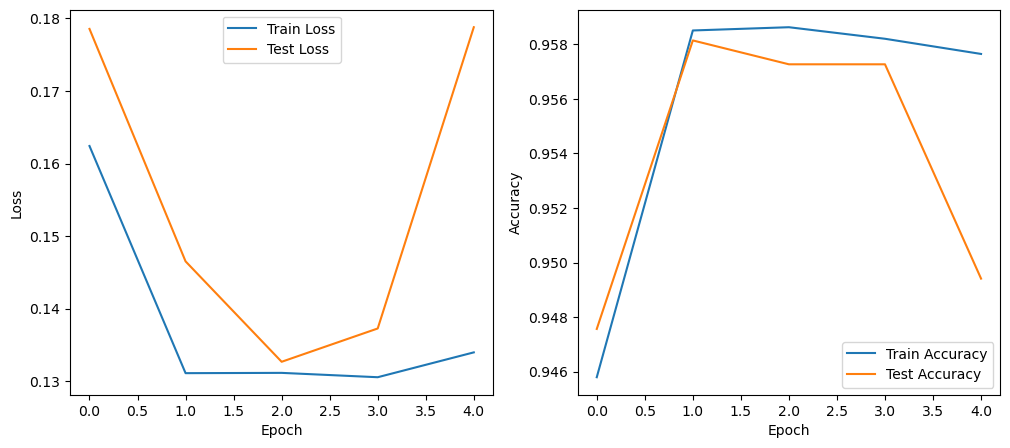

In [97]:

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, optimizers, criterion, num_epochs, device
)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [98]:
adamw_ = {
               'test_losses': test_losses,
               'train_losses':train_losses,
               'train_accuracies':train_accuracies,
               'test_accuracies':  test_accuracies
              } 

adamw_

{'test_losses': [0.17855756451699364,
  0.14651074925603455,
  0.13266612403094769,
  0.13725727271281826,
  0.17878969133820907],
 'train_losses': [0.16241411839547845,
  0.13109724776081513,
  0.1311368783892389,
  0.13053733161880074,
  0.13396294315209992],
 'train_accuracies': [0.9457939389325327,
  0.9585127592655155,
  0.9586317156846418,
  0.9582082308325521,
  0.9576515147910412],
 'test_accuracies': [0.9475647589501532,
  0.9581469709369825,
  0.9572714641898707,
  0.9572714641898707,
  0.9494109362212367]}

## MuON  L1->RMS

In [108]:
import torch
from torch import Tensor

def zeropower_via_newtonschulz5_1(G: Tensor, steps: int) -> Tensor:

    assert G.ndim >= 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT


    l1_norm = torch.linalg.norm(X, ord=1, dim=(-2, -1), keepdim=True) 
    X = X / (l1_norm + 1e-7)
    
    rms = torch.sqrt(torch.mean(X**2, dim=(-2, -1), keepdim=True))
    rms = torch.clamp(rms, min=1e-7, max=1e7)  # clip the RMS norm
    X = X / (rms + 1e-7)

    X = torch.clamp(X, min=-1e6, max=1e6)  # clip the values

    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A
        X = a * X + B @ X

    if G.size(-2) > G.size(-1):
        X = X.mT
    return X

class Muon_l1(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz
    """
    def __init__(self, params, lr=0.02, weight_decay=0.01, momentum=0.95, nesterov=True, ns_steps=5):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov, ns_steps=ns_steps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for p in self.param_groups[0]['params']:
            g = p.grad
            assert g is not None
            state = self.state[p]
            if "momentum_buffer" not in state:
                state["momentum_buffer"] = torch.zeros_like(g)
            buf: Tensor = state["momentum_buffer"]
            buf.lerp_(g, 1 - self.param_groups[0]["momentum"])
            g = g.lerp_(buf, self.param_groups[0]["momentum"]) if self.param_groups[0]["nesterov"] else buf
            if g.ndim == 4: # for the case of conv filters
                g = g.view(len(g), -1)
            g = zeropower_via_newtonschulz5_1(g, steps=self.param_groups[0]["ns_steps"]).flatten()
            p.mul_(1 - self.param_groups[0]["lr"] * self.param_groups[0]["weight_decay"])
            p.add_(g.view_as(p),
                   alpha=-self.param_groups[0]["lr"] * max(1, p.size(-2) / p.size(-1) + 1e-7)**0.5)

In [90]:


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        scores = self.Va(torch.tanh(self.Wa(hidden_states) + self.Ua(hidden_states)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.permute(0, 2, 1), hidden_states).squeeze(1)
        return context_vector, attention_weights

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_rate)
        self.attention = Attention(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        context_vector, attention_weights = self.attention(x)
        output = self.fc(context_vector)
        return output


def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []

        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)


            # for opt in optimizer:
            #     opt.zero_grad()
                
            loss.backward()
            
            for opt in optimizer:
                opt.step()

            model.zero_grad(set_to_none=True)
            
            # Collect metrics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_train_preds.extend(predicted.cpu().numpy())
            epoch_train_labels.extend(labels.cpu().numpy())


        epoch_train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)


        model.eval()
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                epoch_test_preds.extend(predicted.cpu().numpy())
                epoch_test_labels.extend(labels.cpu().numpy())

        epoch_test_accuracy = accuracy_score(epoch_test_labels, epoch_test_preds)
        epoch_test_loss /= len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# hyperpams
vocab_size = 119547  
hidden_dim = 256
num_classes = 2  
max_length = 256
num_epochs = 5
batch_size = 8
learning_rate = .001
weight_decay = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes, max_length)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

muon_params = [p for p in model.rnn.parameters() if p.ndim >= 2]
adamw_params = ([p for p in model.rnn.parameters() if p.ndim < 2]
              + list(model.embedding.parameters())
              + list(model.attention.parameters())
              + list(model.fc.parameters())
              + list(model.dropout.parameters()))

mu_opti = Muon_l1(muon_params, lr=0.02, momentum=0.95)

optimizers = [
    mu_opti,
    torch.optim.AdamW(adamw_params, lr=learning_rate, betas=(0.90, 0.95), weight_decay=0.01)
]

for opt in optimizers:
    for group in opt.param_groups:
        group["initial_lr"] = group["lr"]

100%|██████████| 26271/26271 [25:05<00:00, 17.45it/s]


Epoch 1/5:
Train Loss: 0.4559, Train Accuracy: 0.8165
Test Loss: 0.4478, Test Accuracy: 0.8156


100%|██████████| 26271/26271 [25:06<00:00, 17.43it/s]


Epoch 2/5:
Train Loss: 0.4739, Train Accuracy: 0.8101
Test Loss: 0.4590, Test Accuracy: 0.8120


100%|██████████| 26271/26271 [25:09<00:00, 17.40it/s]


Epoch 3/5:
Train Loss: 0.4749, Train Accuracy: 0.8107
Test Loss: 0.4791, Test Accuracy: 0.8008


100%|██████████| 26271/26271 [25:09<00:00, 17.40it/s]


Epoch 4/5:
Train Loss: 0.4772, Train Accuracy: 0.8100
Test Loss: 0.4693, Test Accuracy: 0.8098


100%|██████████| 26271/26271 [25:09<00:00, 17.41it/s]


Epoch 5/5:
Train Loss: 0.4808, Train Accuracy: 0.8099
Test Loss: 0.4602, Test Accuracy: 0.8061


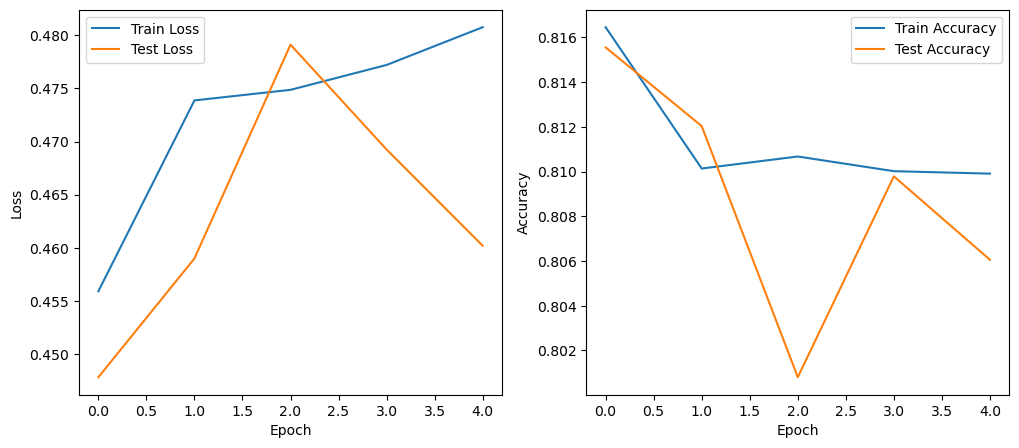

In [92]:

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, optimizers, criterion, num_epochs, device
)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [93]:
muon_l1_rms = {
               'test_losses': test_losses,
               'train_losses':train_losses,
               'train_accuracies':train_accuracies,
               'test_accuracies':  test_accuracies
              } 

muon_l1_rms

{'test_losses': [0.4478307020556676,
  0.45900218879370686,
  0.4791118669438195,
  0.4692504374451037,
  0.4602013078226677],
 'train_losses': [0.45591453960079803,
  0.473868304338407,
  0.47486341524924364,
  0.4772038891794378,
  0.4807529138573937],
 'train_accuracies': [0.8164550035449013,
  0.8101360385609129,
  0.8106737215753637,
  0.8100170821417866,
  0.8099076422361904],
 'test_accuracies': [0.8155535676899944,
  0.8120325079461753,
  0.8008031822766982,
  0.80978664281228,
  0.8060562227593688]}

## Важный эксперимент

Вообще я тут ещё посидел покумекал над оптимизатором и там чтобы затестить уменьшил размер нейронной сети... захочу может отдельно обсудить, тут не успеет отработать, но первичные результаты сильно лучше MuON выше. Выводы в презе.

In [117]:


def zeropower_via_newtonschulz5_1(G: Tensor, steps: int) -> Tensor:

    assert G.ndim >= 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT


    l1_norm = X.abs().sum(dim=(-2, -1), keepdim=True) + 1e-7
    # Normalize by L1 norm
    X = X / l1_norm
    # Scale to ensure RMS is 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)

    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A
        X = a * X + B @ X

    if G.size(-2) > G.size(-1):
        X = X.mT
    return X

class Muon_l1(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz
    """
    def __init__(self, params, lr=0.02, weight_decay=0.01, momentum=0.95, nesterov=True, ns_steps=5):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov, ns_steps=ns_steps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for p in self.param_groups[0]['params']:
            g = p.grad
            assert g is not None
            state = self.state[p]
            if "momentum_buffer" not in state:
                state["momentum_buffer"] = torch.zeros_like(g)
            buf: torch.Tensor = state["momentum_buffer"]
            buf.lerp_(g, 1 - self.param_groups[0]["momentum"])
            g = g.lerp_(buf, self.param_groups[0]["momentum"]) if self.param_groups[0]["nesterov"] else buf

            if g.ndim == 4:  # for the case of conv filters
                g = g.view(len(g), -1)

            # Check for NaN values in the gradient before normalization
            if torch.isnan(g).any():
                print("NaN values detected in gradient before normalization")
                continue

            g = zeropower_via_newtonschulz5_1(g, steps=self.param_groups[0]["ns_steps"]).flatten()

            # Check for NaN values in the gradient after normalization
            if torch.isnan(g).any():
                print("NaN values detected in gradient after normalization")
                continue

            p.mul_(1 - self.param_groups[0]["lr"] * self.param_groups[0]["weight_decay"])
            p.add_(g.view_as(p),
                   alpha=-self.param_groups[0]["lr"] * max(1, p.size(-2) / p.size(-1) + 1e-7)**0.5)

            # Check for NaN values in the parameters after update
            if torch.isnan(p).any():
                print("NaN values detected in parameters after update")
                continue


In [123]:


class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        scores = self.Va(torch.tanh(self.Wa(hidden_states) + self.Ua(hidden_states)))
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.bmm(attention_weights.permute(0, 2, 1), hidden_states).squeeze(1)
        return context_vector, attention_weights

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length, dropout_rate=0.5):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout_rate)
        self.attention = Attention(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        context_vector, attention_weights = self.attention(x)
        output = self.fc(context_vector)
        return output


def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, device):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []

        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)


            # for opt in optimizer:
            #     opt.zero_grad()
                
            loss.backward()
            
            for opt in optimizer:
                opt.step()

            model.zero_grad(set_to_none=True)
            
            # Collect metrics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_train_preds.extend(predicted.cpu().numpy())
            epoch_train_labels.extend(labels.cpu().numpy())


        epoch_train_accuracy = accuracy_score(epoch_train_labels, epoch_train_preds)
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)


        model.eval()
        epoch_test_loss = 0
        epoch_test_preds = []
        epoch_test_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                epoch_test_preds.extend(predicted.cpu().numpy())
                epoch_test_labels.extend(labels.cpu().numpy())

        epoch_test_accuracy = accuracy_score(epoch_test_labels, epoch_test_preds)
        epoch_test_loss /= len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

# hyperpams
vocab_size = 119547  
hidden_dim = 16
num_classes = 2  
max_length = 256
num_epochs = 5
batch_size = 8
learning_rate = .001
weight_decay = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize
model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes, max_length)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

muon_params = [p for p in model.rnn.parameters() if p.ndim >= 2]
adamw_params = ([p for p in model.rnn.parameters() if p.ndim < 2]
              + list(model.embedding.parameters())
              + list(model.attention.parameters())
              + list(model.fc.parameters())
              + list(model.dropout.parameters()))

mu_opti = Muon_l1(muon_params, lr=0.001, momentum=0.95)

optimizers = [
    mu_opti,
    torch.optim.AdamW(adamw_params, lr=learning_rate, betas=(0.90, 0.95), weight_decay=0.01)
]

for opt in optimizers:
    for group in opt.param_groups:
        group["initial_lr"] = group["lr"]

In [124]:

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, optimizers, criterion, num_epochs, device
)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

100%|██████████| 26271/26271 [09:02<00:00, 48.43it/s]


Epoch 1/5:
Train Loss: 0.1690, Train Accuracy: 0.9393
Test Loss: 0.1285, Test Accuracy: 0.9550


100%|██████████| 26271/26271 [09:47<00:00, 44.73it/s]


Epoch 2/5:
Train Loss: 0.1213, Train Accuracy: 0.9589
Test Loss: 0.1232, Test Accuracy: 0.9589


  1%|          | 175/26271 [00:03<08:10, 53.15it/s]


KeyboardInterrupt: 

In [ ]:
# Случайно обнулил ячейку, в презе чуть другие цифры, потому что с первого прохода остались. 

# Результаты

ADAMW лучше себя показывает. 

Однако по последней экспериментальной ячейке есть подозрения, что причиной может быть архитектура сети. Или же выбранные гиперпараметры. Надо бы поисследовать ещё.

# Старая попытка потренить LLM из репозитория MuON

### ВСЕ ЧТО НИЖЕ ОСТАВЛЕНО ТОЛЬКО ДЛЯ ДЕМОНСТРАЦИИ, ЧТО Я ПИТЫАЛСЯ И LLM ПОТРЕНИТЬ НА СВОИХ РЕСУРСАХ.

Упёрся в очень долгое обучение. Смотреть на предмет решений для оценки не нужно. Если по каким-то неведомым мне причинам хочется, то прошу делать строго под 

https://music.yandex.ru/album/30651393/track/124684206?utm_source=web&utm_medium=copy_link

In [13]:
class MoonDataset(Dataset):
    def __init__(self, dataset_name, dataset, tokenizer, max_length=256):
        self.dataset_name = dataset_name
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.texts = dataset["train"]["text"]
        self.max_length = max_length
        self.tokens = []
        self._tokenize_texts()

    def _tokenize_texts(self):
        if os.path.exists(f"{self.dataset_name}.bin"):
            self.tokens = torch.load(f"{self.dataset_name}.bin")
        else:
            for text in tqdm(self.texts, desc="Tokenizing texts"):
                encoded = self.tokenizer.encode(text, add_special_tokens=True)
                self.tokens.extend(encoded)
            torch.save(self.tokens, f"{self.dataset_name}.bin")

    def __len__(self):
        return len(self.tokens) // self.max_length

    def __getitem__(self, idx):
        start_idx = idx * (self.max_length)
        end_idx = start_idx + (self.max_length)
        token_slice = self.tokens[start_idx:end_idx]
        data = torch.tensor(token_slice, dtype=torch.long)
        return data

In [44]:
# This code snippet is a modified version adapted from the following GitHub repository:
# https://github.com/KellerJordan/Muon/blob/master/muon.py
@torch.compile
def zeropower_via_newtonschulz5(G, steps):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T
    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = (
            b * A + c * A @ A
        )  # adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(0) > G.size(1):
        X = X.T
    return X

In [ ]:
# This code snippet is a modified version adapted from the following GitHub repository:
# https://github.com/KellerJordan/Muon/blob/master/muon.py
@torch.compile
def zeropower_via_newtonschulz5(G, steps):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T
    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = (
            b * A + c * A @ A
        )  # adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(0) > G.size(1):
        X = X.T
    return X
class Muon_default(torch.optim.Optimizer):

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

In [15]:
class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - We believe this optimizer is unlikely to work well for training with small batch size.
    - We believe it may not work well for finetuning pretrained models, but we haven't tested this.

    Arguments:
        muon_params: The parameters to be optimized by Muon.
        lr: The learning rate. The updates will have spectral norm of `lr`. (0.02 is a good default)
        momentum: The momentum used by the internal SGD. (0.95 is a good default)
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        ns_steps: The number of Newton-Schulz iterations to run. (6 is probably always enough)
        adamw_params: The parameters to be optimized by AdamW. Any parameters in `muon_params` which are
        {0, 1}-D or are detected as being the embed or lm_head will be optimized by AdamW as well.
        adamw_lr: The learning rate for the internal AdamW.
        adamw_betas: The betas for the internal AdamW.
        adamw_eps: The epsilon for the internal AdamW.
        adamw_wd: The weight decay for the internal AdamW.
    """

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

                # RMS-L1 Normalization for the final layer
                if "lm_head.weight" in p.name:  # Adjust this condition if your final layer has a different name
                    w = p.data
                    rms = torch.sqrt(torch.mean(w**2))
                    l1 = torch.sum(torch.abs(w))
                    p.data = w / (rms + 1e-8)  # Add a small epsilon to avoid division by zero
                    p.data = p.data / (torch.sum(torch.abs(p.data)) + 1e-8)



            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

In [45]:
class Muon_default(torch.optim.Optimizer):

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

In [17]:
def get_model_and_dataloader(model_name, dataset_name, hidden_size):
    name2path = {
        "openwebtext-100k": "Elriggs/openwebtext-100k",
    }
    train_dataset = load_dataset(name2path[dataset_name], trust_remote_code=True)
    if model_name == "qwen":
        tokenizer = Qwen2Tokenizer.from_pretrained(
            "Qwen/Qwen2.5-0.5B", trust_remote_code=True
        )
    else:
        assert 0, f"model {model_name} not supported"
    train_dataset = MoonDataset(dataset_name, train_dataset, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    if model_name == "qwen":
        config = Qwen2Config(
            attention_dropout=0.0,
            bos_token_id=151643,
            eos_token_id=151643,
            hidden_act="silu",
            hidden_size=hidden_size,
            initializer_range=0.02,
            intermediate_size=2048, # Reduce from 4864,
            max_position_embeddings=513,
            max_window_layers=12,
            model_type="qwen2",
            num_hidden_layers=6,  # Reduce from 12
            num_attention_heads=8,  # Reduce from 16
            num_key_value_heads=16,
            rms_norm_eps=1e-06,
            rope_theta=1000000.0,
            sliding_window=1024,
            tie_word_embeddings=True,
            torch_dtype="bfloat16",
            use_cache=True,
            use_mrope=False,
            use_sliding_window=False,
            vocab_size=151936,
        )
        model = Qwen2ForCausalLM(config)
    else:
        assert 0, f"model {model_name} not supported"
    return model, train_loader


def get_optimizer(optimizer_name, model, lr=1e-3, wd=0.1):
    if optimizer_name == "adamw":
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd, betas=(0.9, 0.95)
        )
    elif optimizer_name == "muon":
        muon_params = [
            p
            for name, p in model.named_parameters()
            if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
        ]
        adamw_params = [
            p
            for name, p in model.named_parameters()
            if not (
                p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            )
        ]

        return Muon(
            lr=lr,
            wd=wd,
            muon_params=muon_params,
            adamw_params=adamw_params,
        )
    else:
        assert 0, "optimizer not supported"

In [18]:
# Cell 6: Configure training parameters

model_name = "qwen"  
optimizer_name = "muon"  # Options: "adamw", "muon"
learning_rate = 1e-3
weight_decay = 0.1
dataset_name = "openwebtext-100k"
hidden_size = 512

# Setup logging
logger.add(f"logs/train_{model_name}_{optimizer_name}_lr{learning_rate}.log")

2

In [19]:
# Cell 7: Initialize model and optimizer
model, train_loader = get_model_and_dataloader(
    model_name, dataset_name, hidden_size
)

def get_optimizer(optimizer_name, model, lr=1e-3, wd=0.1):
    if optimizer_name == "adamw":
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd, betas=(0.9, 0.95)
        )
    elif optimizer_name == "muon":
        muon_params = [
            p
            for name, p in model.named_parameters()
            if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
        ]
        adamw_params = [
            p
            for name, p in model.named_parameters()
            if not (
                p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            )
        ]

        return Muon(
            lr=lr,
            wd=wd,
            muon_params=muon_params,
            adamw_params=adamw_params,
        )
    else:
        assert 0, "optimizer not supported"
optimizer = get_optimizer(
    optimizer_name, model, lr=learning_rate, wd=weight_decay
)

In [20]:
# Cell 8: Setup device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 512)
    (layers): ModuleList(
      (0-5): 6 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (k_proj): Linear(in_features=512, out_features=1024, bias=True)
          (v_proj): Linear(in_features=512, out_features=1024, bias=True)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=512, out_features=2048, bias=False)
          (up_proj): Linear(in_features=512, out_features=2048, bias=False)
          (down_proj): Linear(in_features=2048, out_features=512, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((512,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((512,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((512,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [11]:
# Cell 9: Training loop
model.train()
num_epochs = 2
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * num_epochs,
    num_cycles=0.5,
)

for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = batch.to(device)
        input_ids = batch
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Log to file
        logger.info(
            f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']} Training loss: {loss.item()}"
        )
        
        # For Jupyter notebook display (print less frequently to avoid cluttering)
        if step % 20 == 0:
            print(f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']:.6f} Training loss: {loss.item():.4f}")

RuntimeError: The size of tensor a (8) must match the size of tensor b (0) at non-singleton dimension 1

# Basic version

In [11]:
# Cell 9: Training loop
model.train()
num_epochs = 2
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * num_epochs,
    num_cycles=0.5,
)

for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = batch.to(device)
        input_ids = batch
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Log to file
        logger.info(
            f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']} Training loss: {loss.item()}"
        )
        
        # For Jupyter notebook display (print less frequently to avoid cluttering)
        if step % 20 == 0:
            print(f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']:.6f} Training loss: {loss.item():.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 152.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.67 GiB is allocated by PyTorch, and 20.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# To run

In [1]:
# cell 1 

import os
import math
import torch
from loguru import logger
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Qwen2Config,
    Qwen2ForCausalLM,
    Qwen2Tokenizer,
    get_cosine_schedule_with_warmup,
)
from tqdm import tqdm

from transformers import BitsAndBytesConfig

from torch.cuda.amp import autocast, GradScaler
import numpy as np
from torch.optim import AdamW
from accelerate import Accelerator



# cell 2
class MoonDataset(Dataset):
    def __init__(self, dataset_name, dataset, tokenizer, max_length=256):
        self.dataset_name = dataset_name
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.texts = dataset["train"]["text"]
        self.max_length = max_length
        self.tokens = []
        self._tokenize_texts()

    def _tokenize_texts(self):
        cache_path = f"{self.dataset_name}.bin"
        if os.path.exists(cache_path):
            self.tokens = torch.load(cache_path)
            print(f"Loaded tokenized data from {cache_path}")
        else:
            print("Tokenizing texts...")
            all_tokens = []
            for text in tqdm(self.texts, desc="Tokenizing texts"):
                # Add proper tokenization with padding/truncation
                encoded = self.tokenizer.encode(text, add_special_tokens=True, 
                                               max_length=self.max_length, 
                                               truncation=True)
                all_tokens.extend(encoded)
            self.tokens = all_tokens
            torch.save(self.tokens, cache_path)
            print(f"Saved tokenized data to {cache_path}")

    def __len__(self):
        return max(1, len(self.tokens) // self.max_length)

    def __getitem__(self, idx):
        start_idx = idx * self.max_length
        end_idx = min(start_idx + self.max_length, len(self.tokens))
        
        # Make sure we have exactly max_length tokens
        token_slice = self.tokens[start_idx:end_idx]
        
        # Pad if necessary
        if len(token_slice) < self.max_length:
            token_slice = token_slice + [self.tokenizer.pad_token_id] * (self.max_length - len(token_slice))
            
        data = torch.tensor(token_slice, dtype=torch.long)
        return data

# cell 3
# This code snippet is a modified version adapted from the following GitHub repository:
# https://github.com/KellerJordan/Muon/blob/master/muon.py
@torch.compile
def zeropower_via_newtonschulz5(G, steps):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T
    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = (
            b * A + c * A @ A
        )  # adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(0) > G.size(1):
        X = X.T
    return X

# cell 4
class Muon_default(torch.optim.Optimizer):

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

# Cell 5
def get_model_and_dataloader(model_name, dataset_name, hidden_size):
    name2path = {
        "openwebtext-100k": "Elriggs/openwebtext-100k",
    }
    train_dataset = load_dataset(name2path[dataset_name], trust_remote_code=True)
    if model_name == "qwen":
        tokenizer = Qwen2Tokenizer.from_pretrained(
            "Qwen/Qwen2.5-0.5B", trust_remote_code=True
        )
    else:
        assert 0, f"model {model_name} not supported"
    train_dataset = MoonDataset(dataset_name, train_dataset, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    if model_name == "qwen":
        config = Qwen2Config(
            attention_dropout=0.0,
            bos_token_id=151643,
            eos_token_id=151643,
            hidden_act="silu",
            hidden_size=hidden_size,
            initializer_range=0.02,
            intermediate_size=4864, # Reduce from 4864,
            max_position_embeddings=513,
            max_window_layers=12,
            model_type="qwen2",
            num_hidden_layers=12,  # Reduce from 12
            num_attention_heads=16,  # Reduce from 16
            num_key_value_heads=16,
            rms_norm_eps=1e-06,
            rope_theta=1000000.0,
            sliding_window=1024,
            tie_word_embeddings=True,
            torch_dtype="bfloat16",
            use_cache=True,
            use_mrope=False,
            use_sliding_window=False,
            vocab_size=151936,
        )
        model = Qwen2ForCausalLM(config)
    else:
        assert 0, f"model {model_name} not supported"
    return model, train_loader


def get_optimizer(optimizer_name, model, lr=1e-3, wd=0.1):
    if optimizer_name == "adamw":
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd, betas=(0.9, 0.95)
        )
    elif optimizer_name == "muon":
        muon_params = [
            p
            for name, p in model.named_parameters()
            if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
        ]
        adamw_params = [
            p
            for name, p in model.named_parameters()
            if not (
                p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            )
        ]

        return Muon_default(
            lr=lr,
            wd=wd,
            muon_params=muon_params,
            adamw_params=adamw_params,
        )
    else:
        assert 0, "optimizer not supported"

# Cell 6: Configure training parameters
# Set your parameters here
model_name = "qwen"  # Options: "qwen"
optimizer_name = "muon"  # Options: "adamw", "muon"
learning_rate = 1e-3
weight_decay = 0.1
dataset_name = "openwebtext-100k"
hidden_size = 1024

# Setup logging
logger.add(f"logs/train_{model_name}_{optimizer_name}_lr{learning_rate}.log")


# Cell 7: Initialize model and optimizer
model, train_loader = get_model_and_dataloader(
    model_name, dataset_name, hidden_size
)
optimizer = get_optimizer(
    optimizer_name, model, lr=learning_rate, wd=weight_decay
)


# Cell 8: Setup device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Cell 9: Training loop (Fixed version)


Loaded tokenized data from openwebtext-100k.bin


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-11): 12 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=4864, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1024,), eps=1e-06)
    (rotary_emb): 

In [3]:
# Cell 9: Training loop (Fixed version)
model.train()
num_epochs = 2
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * num_epochs,
    num_cycles=0.5,
)

scaler = GradScaler()  # For mixed precision training
lr_params = []
step_params = []
loss_params = []

for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        batch = batch.to(device)
        
        # Make sure batch has the right shape [batch_size, sequence_length]
        if len(batch.shape) == 1:
            batch = batch.unsqueeze(0)  # Add batch dimension if missing
            
        # For causal language modeling, inputs are the tokens and labels are the same tokens
        # The model will automatically shift the labels by one position
        inputs = batch
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=inputs, labels=inputs)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        lr_scheduler.step()
        
        total_loss += loss.item()
        
        # Log to file
        # logger.info(
        #     f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']} Training loss: {loss.item()}"
        # )
        
        # For Jupyter notebook display (print less frequently to avoid cluttering)
        if step % 50 == 0:
            lr_params.append(optimizer.param_groups[0]['lr'])
            step_params.append(step)
            loss_params.append(loss.item())
            print(f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']:.6f} Training loss: {loss.item():.4f}")

C:\Users\Professional\AppData\Local\Temp\ipykernel_8752\3092051002.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
W0413 22:07:41.243000 8752 site-packages\torch\_inductor\utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
C:\Users\Professional\anaconda3\envs\neuro_env\Lib\site-packages\torch\_inductor\compile_fx.py:1948: UserWarning: NVIDIA GeForce GTX 1060 6GB does not support bfloat16 compilation natively, skipping
  warnings.warn(


Epoch: 0 Step: 0 LR: 0.000010 Training loss: 12.1447
Epoch: 0 Step: 50 LR: 0.000510 Training loss: 7.7767


KeyboardInterrupt: 

# To ask from LLM

In [ ]:
# cell 1 

import os
import math
import torch
from loguru import logger
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import (
    Qwen2Config,
    Qwen2ForCausalLM,
    Qwen2Tokenizer,
    get_cosine_schedule_with_warmup,
)
from tqdm import tqdm

from transformers import BitsAndBytesConfig

from torch.cuda.amp import autocast, GradScaler
import numpy as np
from torch.optim import AdamW
from accelerate import Accelerator



# cell 2
class MoonDataset(Dataset):
    def __init__(self, dataset_name, dataset, tokenizer, max_length=256):
        self.dataset_name = dataset_name
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.texts = dataset["train"]["text"]
        self.max_length = max_length
        self.tokens = []
        self._tokenize_texts()

    def _tokenize_texts(self):
        cache_path = f"{self.dataset_name}.bin"
        if os.path.exists(cache_path):
            self.tokens = torch.load(cache_path)
            print(f"Loaded tokenized data from {cache_path}")
        else:
            print("Tokenizing texts...")
            all_tokens = []
            for text in tqdm(self.texts, desc="Tokenizing texts"):
                # Add proper tokenization with padding/truncation
                encoded = self.tokenizer.encode(text, add_special_tokens=True, 
                                               max_length=self.max_length, 
                                               truncation=True)
                all_tokens.extend(encoded)
            self.tokens = all_tokens
            torch.save(self.tokens, cache_path)
            print(f"Saved tokenized data to {cache_path}")

    def __len__(self):
        return max(1, len(self.tokens) // self.max_length)

    def __getitem__(self, idx):
        start_idx = idx * self.max_length
        end_idx = min(start_idx + self.max_length, len(self.tokens))
        
        # Make sure we have exactly max_length tokens
        token_slice = self.tokens[start_idx:end_idx]
        
        # Pad if necessary
        if len(token_slice) < self.max_length:
            token_slice = token_slice + [self.tokenizer.pad_token_id] * (self.max_length - len(token_slice))
            
        data = torch.tensor(token_slice, dtype=torch.long)
        return data

# cell 3
# This code snippet is a modified version adapted from the following GitHub repository:
# https://github.com/KellerJordan/Muon/blob/master/muon.py
@torch.compile
def zeropower_via_newtonschulz5(G, steps):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    if G.size(0) > G.size(1):
        X = X.T
    # Ensure spectral norm is at most 1
    X = X / (X.norm() + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.T
        B = (
            b * A + c * A @ A
        )  # adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(0) > G.size(1):
        X = X.T
    return X

# cell 4
class Muon_default(torch.optim.Optimizer):

    def __init__(
        self,
        lr=1e-3,
        wd=0.1,
        muon_params=None,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        adamw_params=None,
        adamw_betas=(0.9, 0.95),
        adamw_eps=1e-8,
    ):

        defaults = dict(
            lr=lr,
            wd=wd,
            momentum=momentum,
            nesterov=nesterov,
            ns_steps=ns_steps,
            adamw_betas=adamw_betas,
            adamw_eps=adamw_eps,
        )

        params = list(muon_params)
        adamw_params = list(adamw_params) if adamw_params is not None else []
        params.extend(adamw_params)
        super().__init__(params, defaults)
        # Sort parameters into those for which we will use Muon, and those for which we will not
        for p in muon_params:
            # Use Muon for every parameter in muon_params which is >= 2D and doesn't look like an embedding or head layer
            assert p.ndim == 2, p.ndim
            self.state[p]["use_muon"] = True
        for p in adamw_params:
            # Do not use Muon for parameters in adamw_params
            self.state[p]["use_muon"] = False

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:

            ############################
            #           Muon           #
            ############################

            params = [p for p in group["params"] if self.state[p]["use_muon"]]
            # import pdb; pdb.set_trace()
            lr = group["lr"]
            wd = group["wd"]
            momentum = group["momentum"]

            # generate weight updates in distributed fashion
            for p in params:
                # sanity check
                g = p.grad
                if g is None:
                    continue
                if g.ndim > 2:
                    g = g.view(g.size(0), -1)
                assert g is not None

                # calc update
                state = self.state[p]
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                if group["nesterov"]:
                    g = g.add(buf, alpha=momentum)
                else:
                    g = buf
                u = zeropower_via_newtonschulz5(g, steps=group["ns_steps"])

                # scale update
                adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)

                # apply weight decay
                p.data.mul_(1 - lr * wd)

                # apply update
                p.data.add_(u, alpha=-adjusted_lr)

            ############################
            #       AdamW backup       #
            ############################

            params = [p for p in group["params"] if not self.state[p]["use_muon"]]
            lr = group['lr']
            beta1, beta2 = group["adamw_betas"]
            eps = group["adamw_eps"]
            weight_decay = group["wd"]

            for p in params:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if "step" not in state:
                    state["step"] = 0
                    state["moment1"] = torch.zeros_like(g)
                    state["moment2"] = torch.zeros_like(g)
                state["step"] += 1
                step = state["step"]
                buf1 = state["moment1"]
                buf2 = state["moment2"]
                buf1.lerp_(g, 1 - beta1)
                buf2.lerp_(g.square(), 1 - beta2)

                g = buf1 / (eps + buf2.sqrt())

                bias_correction1 = 1 - beta1**step
                bias_correction2 = 1 - beta2**step
                scale = bias_correction1 / bias_correction2**0.5
                p.data.mul_(1 - lr * weight_decay)
                p.data.add_(g, alpha=-lr / scale)

        return loss

# Cell 5
def get_model_and_dataloader(model_name, dataset_name, hidden_size):
    name2path = {
        "openwebtext-100k": "Elriggs/openwebtext-100k",
    }
    train_dataset = load_dataset(name2path[dataset_name], trust_remote_code=True)
    if model_name == "qwen":
        tokenizer = Qwen2Tokenizer.from_pretrained(
            "Qwen/Qwen2.5-0.5B", trust_remote_code=True
        )
    else:
        assert 0, f"model {model_name} not supported"
    train_dataset = MoonDataset(dataset_name, train_dataset, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    if model_name == "qwen":
        config = Qwen2Config(
            attention_dropout=0.0,
            bos_token_id=151643,
            eos_token_id=151643,
            hidden_act="silu",
            hidden_size=hidden_size,
            initializer_range=0.02,
            intermediate_size=4864, # Reduce from 4864,
            max_position_embeddings=513,
            max_window_layers=12,
            model_type="qwen2",
            num_hidden_layers=12,  # Reduce from 12
            num_attention_heads=16,  # Reduce from 16
            num_key_value_heads=16,
            rms_norm_eps=1e-06,
            rope_theta=1000000.0,
            sliding_window=1024,
            tie_word_embeddings=True,
            torch_dtype="bfloat16",
            use_cache=True,
            use_mrope=False,
            use_sliding_window=False,
            vocab_size=151936,
        )
        model = Qwen2ForCausalLM(config)
    else:
        assert 0, f"model {model_name} not supported"
    return model, train_loader


def get_optimizer(optimizer_name, model, lr=1e-3, wd=0.1):
    if optimizer_name == "adamw":
        return torch.optim.AdamW(
            model.parameters(), lr=lr, weight_decay=wd, betas=(0.9, 0.95)
        )
    elif optimizer_name == "muon":
        muon_params = [
            p
            for name, p in model.named_parameters()
            if p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
        ]
        adamw_params = [
            p
            for name, p in model.named_parameters()
            if not (
                p.ndim >= 2 and "embed_tokens" not in name and "lm_head" not in name
            )
        ]

        return Muon_default(
            lr=lr,
            wd=wd,
            muon_params=muon_params,
            adamw_params=adamw_params,
        )
    else:
        assert 0, "optimizer not supported"

# Cell 6: Configure training parameters
# Set your parameters here
model_name = "qwen"  # Options: "qwen"
optimizer_name = "muon"  # Options: "adamw", "muon"
learning_rate = 1e-3
weight_decay = 0.1
dataset_name = "openwebtext-100k"
hidden_size = 1024

# Setup logging
logger.add(f"logs/train_{model_name}_{optimizer_name}_lr{learning_rate}.log")


# Cell 7: Initialize model and optimizer
model, train_loader = get_model_and_dataloader(
    model_name, dataset_name, hidden_size
)
optimizer = get_optimizer(
    optimizer_name, model, lr=learning_rate, wd=weight_decay
)


# Cell 8: Setup device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Cell 9: Training loop (Fixed version)
model.train()
num_epochs = 2
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * num_epochs,
    num_cycles=0.5,
)

scaler = GradScaler()  # For mixed precision training

for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        batch = batch.to(device)
        
        # Make sure batch has the right shape [batch_size, sequence_length]
        if len(batch.shape) == 1:
            batch = batch.unsqueeze(0)  # Add batch dimension if missing
            
        # For causal language modeling, inputs are the tokens and labels are the same tokens
        # The model will automatically shift the labels by one position
        inputs = batch
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=inputs, labels=inputs)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        lr_scheduler.step()
        
        total_loss += loss.item()
        
        # Log to file
        logger.info(
            f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']} Training loss: {loss.item()}"
        )
        
        # For Jupyter notebook display (print less frequently to avoid cluttering)
        if step % 20 == 0:
            print(f"Epoch: {epoch} Step: {step} LR: {optimizer.param_groups[0]['lr']:.6f} Training loss: {loss.item():.4f}")